In [ ]:
!pip install transformers
!pip install nltk

     |████████████████████████████████| 1.1MB 5.5MB/s 
     |████████████████████████████████| 3.0MB 31.5MB/s 
     |████████████████████████████████| 890kB 38.5MB/s 
     |████████████████████████████████| 1.1MB 51.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=eed9cb519bd6990d403319156fbe84d47e2fc46066745e5736b8a81c65ebf8c2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import os
import io
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, BertForPreTraining
import nltk
from sklearn.model_selection import train_test_split
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/train/text

/content/drive/My Drive/MeasEval-main/data/train/train/text


In [ ]:
files=os.listdir()

In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/dev/text

/content/drive/My Drive/MeasEval-main/data/train/dev/text


In [ ]:
files_val=os.listdir()

In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/train

/content/drive/My Drive/MeasEval-main/data/train/train


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):

    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """
    # print(len(sentence))
    # print(len(text_labels))
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)
    # print(len(tokenized_sentence))
    # print(len(labels))
    return tokenized_sentence, labels

In [ ]:
l=0
NERdata=[]
for i in files:
  
  pathtxt=os.path.join('text',i)
  
  with open(pathtxt, 'r') as f:
    text=f.read()
  pathtsv=os.path.join('tsv',i[:-3]+'tsv')
  if(not(os.path.exists(pathtsv))):
    continue
  filetsv=pd.read_csv(pathtsv,sep = '\t')
  entity=filetsv[['annotType','startOffset','endOffset','text']]
  entity = entity.to_numpy().tolist()

  ent=0
  offset=0
  sent_text = nltk.sent_tokenize(text)
  
  for j in sent_text:
    row=[]
    row.append(i[:-4])
    
    
    ent_sen=[]
    ret = [(m.group(0), m.start(), m.end() - 1) for m in re.finditer(r'\S+', j)]
    start=[]
    
    for word in ret:
      types=[]
      for ent_doc in entity:
        if(offset+word[1]>=ent_doc[1] and offset+word[2]<=ent_doc[2]):
          types.append(ent_doc[0])

      ent_sen.append(types)     
    
    
    sen,label=tokenize_and_preserve_labels(j.split(' '),ent_sen,tokenizer)
    label.insert(0,[])
    label.append([])
    offset+=(1+len(j))

    row.append(j)
    row.append(label)
    NERdata.append(row)
    
  
  
  
  

In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/dev

/content/drive/My Drive/MeasEval-main/data/train/dev


In [ ]:
l=0
NERdata_val=[]

for i in files_val:
  
  pathtxt=os.path.join('text',i)
  
  with open(pathtxt, 'r') as f:
    text=f.read()
  pathtsv=os.path.join('tsv',i[:-3]+'tsv')
  if(not(os.path.exists(pathtsv))):
    continue
  filetsv=pd.read_csv(pathtsv,sep = '\t')
  entity=filetsv[['annotType','startOffset','endOffset','text']]
  entity = entity.to_numpy().tolist()

  ent=0
  offset=0
  sent_text = nltk.sent_tokenize(text)
  
  for j in sent_text:
    row=[]
    row.append(i[:-4])
    
    
    ent_sen=[]
    ret = [(m.group(0), m.start(), m.end() - 1) for m in re.finditer(r'\S+', j)]
    start=[]
    
    for word in ret:
      types=[]
      for ent_doc in entity:
        if(offset+word[1]>=ent_doc[1] and offset+word[2]<=ent_doc[2]):
          types.append(ent_doc[0])

      ent_sen.append(types)     
    
    
    sen,label=tokenize_and_preserve_labels(j.split(' '),ent_sen,tokenizer)
    label.insert(0,[])
    label.append([])
    offset+=(1+len(j))

    row.append(j)
    row.append(label)
    NERdata_val.append(row)
    
  
  
  
  

In [ ]:
print(len(NERdata))
print(len(NERdata_val))

1370
199


In [ ]:
NERdf=pd.DataFrame (NERdata, columns = ['Id','Text','Entity'])
NERdf_val=pd.DataFrame (NERdata_val, columns = ['Id','Text','Entity'])

In [ ]:
def len_text(x):
  sum = 0
  for en in x:
    if en == ['MeasuredProperty']:
      sum += len(en)
  return sum

In [ ]:
NERdf1=pd.DataFrame (NERdata, columns = ['Id','Text','Entity'])

In [ ]:
NERdf["len"] = NERdf["Entity"].apply(lambda x: len_text(x))

In [ ]:
NERdf_nz = NERdf[NERdf["len"] != 0]

In [ ]:
NERdf_z = NERdf[NERdf["len"] == 0].sample(500)

In [ ]:
NERdf = pd.concat([NERdf_nz, NERdf_z])

In [ ]:
NERdf = NERdf_nz

In [ ]:
NERdf = NERdf.sample(frac=1)

In [ ]:
len(NERdf)

1370

In [ ]:
NERdf.head(5)

,Id,Text,Entity
0,S0006322312001096-1221,"We constructed Framingham CVD, CHD, and stroke...","[[], [], [], [], [], [], [], [], [], [], [], [..."
1,S0006322312001096-1221,"Crude, age- and sex-adjusted, and multivariabl...","[[], [], [], [], [], [], [], [], [], [], [], [..."
2,S0006322312001096-1221,"In the analysis of GHQ symptoms, the sample wa...","[[], [], [], [], [], [], [], [], [], [], [], [..."
3,S0006322312001096-1221,For depressive symptoms defined by CES-D and a...,"[[], [], [MeasuredEntity], [MeasuredEntity], [..."
4,S0167610513002729-1127,The situation for the 45° case is more interes...,"[[], [], [], [], [], [Quantity], [Quantity], [..."


In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
text_val=NERdf_val['Text'].tolist()
textlabels_val=NERdf_val['Entity'].tolist()

for i in range(len(textlabels_val)):
  textlabels_val[i]=(textlabels_val[i] + 512 * [[]])[:512]
  print(textlabels_val[i])

[[], [], [], [], [], [], [], [], [], [], [], [], [], ['Quantity'], ['MeasuredEntity'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

In [ ]:
text=NERdf['Text'].tolist()
textlabels=NERdf['Entity'].tolist()

for i in range(len(textlabels)):
  textlabels[i]=(textlabels[i] + 512 * [[]])[:512]
  print(textlabels[i])

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

In [ ]:
len(textlabels[1])

512

In [ ]:
inputs = tokenizer(text,max_length = 512,padding='max_length',truncation=True, return_tensors="pt")

In [ ]:
inputs_val = tokenizer(text_val,max_length = 512,padding='max_length',truncation=True, return_tensors="pt")

In [ ]:
import numpy as np

In [ ]:
train_seq = np.array(inputs['input_ids'])
train_mask = np.array(inputs['attention_mask'])
val_seq = np.array(inputs_val['input_ids'])
val_mask = np.array(inputs_val['attention_mask'])

In [ ]:
#labels = {"Quantity":0, "MeasuredEntity": 1, "MeasuredProperty": 2, "Qualifier": 3}
labels = {"MeasuredProperty": 0}

In [ ]:
onehot_labels = np.zeros((len(textlabels), len(textlabels[0]),1));
for i in range(len(textlabels)):
  for j in range(len(textlabels[0])):
      for k in range(len(textlabels[i][j])):
        if textlabels[i][j][k] =="MeasuredProperty":
          onehot_labels[i][j][labels[textlabels[i][j][k]]] = 1

In [ ]:
print(onehot_labels_val[6,:,:])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

In [ ]:
onehot_labels_val = np.zeros((len(textlabels_val), len(textlabels_val[0]),1));
for i in range(len(textlabels_val)):
  for j in range(len(textlabels_val[0])):
      for k in range(len(textlabels_val[i][j])):
        if textlabels_val[i][j][k] =="MeasuredProperty":
          onehot_labels_val[i][j][labels[textlabels_val[i][j][k]]] = 1

In [ ]:
train_y = onehot_labels
val_y = onehot_labels_val
#train_seq, val_seq, train_mask, val_mask, train_y, val_y = train_test_split(train_seq, train_mask, onehot_labels, test_size=0.1, random_state=42)

In [ ]:
print(val_mask.shape)

(199, 512)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_data = TensorDataset(torch.from_numpy(train_seq), torch.from_numpy(train_mask),torch.from_numpy(train_y))
val_data = TensorDataset(torch.from_numpy(val_seq), torch.from_numpy(val_mask),torch.from_numpy(val_y))

In [ ]:
batch_size = 38
train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size = batch_size)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
i=0
for param in model.parameters():
    param.requires_grad = False

In [ ]:
params = list(model.named_parameters())

for p in params:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))



embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)
encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (768,)
encoder.layer.0.attention.output.LayerNorm.weight             (768,)
encoder.layer.0.attention.output.L

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert, embed_dim, hidden_dim, drop_prob, n_layers, out_dim):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.n_layers = n_layers
      self.bilstm = nn.LSTM(embed_dim, hidden_dim, n_layers, bidirectional=True, batch_first=True)
      self.dropout = nn.Dropout(drop_prob)
      self.fc1 = nn.Linear(2*hidden_dim,out_dim)
      self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      embed, cls_hs = self.bert(sent_id, attention_mask=mask)
      x,_ = self.bilstm(embed)
      x = self.dropout(x)
      x = self.fc1(x)
      x = self.sigmoid(x)

      return x

In [ ]:
device = torch.device("cuda")

In [ ]:
bert_model = BERT_Arch(model, 768, 256, 0.5, 1,1)
bert_model = bert_model.to(device)

In [ ]:
print(bert_model)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [ ]:
def weighted_binary_cross_entropy(output, target, weights=None):
    output = torch.clamp(output,min=1e-8,max=1-1e-8)

    if weights is not None:
        assert len(weights) == 2
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [ ]:
from transformers import AdamW

# define the optimizer
criterion = nn.BCELoss()
optimizer = AdamW(bert_model.parameters(), lr = 1e-4)

In [ ]:
epochs =10
for e in range(epochs):
  
  bert_model.train()
  i=0
  train_loss=0
  for seq, mask, y in train_loader:
    bert_model.zero_grad()
    y_pred = bert_model(seq.to(device), mask.to(device))
    loss = criterion(y_pred,y.to(device).float())
    #weights = [1,10]
    #loss = weighted_binary_cross_entropy(y_pred,y.to(device).float(),weights)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*batch_size
    if(i%5==0):
      print("Epoch-{}/{} Iterations-{} loss-{}".format(e+1,epochs,i+1,loss.item()))
    i+=1
  
  
  bert_model.eval()
  val_loss=0
  for seq, mask, y in val_loader:
    bert_model.zero_grad()
    y_pred = bert_model(seq.to(device), mask.to(device))
    loss = criterion(y_pred,y.to(device).float())
    #weights = [1,25]
    #loss = weighted_binary_cross_entropy(y_pred,y.to(device).float(),weights)
    val_loss += loss.item()*batch_size
    
    i+=1
  #if(e%5==0):
  #  torch.save(bert_model,'/content/drive/My Drive/Model/bert_{}.pt'.format(e))
  
  print("Epoch-{}/{} train_loss-{} Val_loss-{}".format(e+1,epochs,train_loss/len(train_loader),val_loss/len(val_loader)))
    
  
  
  

Epoch-1/10 Iterations-1 loss-0.0029666887130588293
Epoch-1/10 Iterations-6 loss-0.0035348208621144295
Epoch-1/10 Iterations-11 loss-0.0027395684737712145
Epoch-1/10 Iterations-16 loss-0.0016467078821733594
Epoch-1/10 Iterations-21 loss-0.003392493585124612
Epoch-1/10 Iterations-26 loss-0.005681673996150494
Epoch-1/10 Iterations-31 loss-0.007539461366832256
Epoch-1/10 Iterations-36 loss-0.005048275459557772
Epoch-1/10 train_loss-0.15781914059216678 Val_loss-0.3625215084757656
Epoch-2/10 Iterations-1 loss-0.006559475790709257
Epoch-2/10 Iterations-6 loss-0.00638212775811553
Epoch-2/10 Iterations-11 loss-0.004237609915435314
Epoch-2/10 Iterations-16 loss-0.0025872187688946724
Epoch-2/10 Iterations-21 loss-0.002795394277200103
Epoch-2/10 Iterations-26 loss-0.0023550009354948997
Epoch-2/10 Iterations-31 loss-0.0072166528552770615
Epoch-2/10 Iterations-36 loss-0.005479772109538317
Epoch-2/10 train_loss-0.1594642796349158 Val_loss-0.3749710211219887
Epoch-3/10 Iterations-1 loss-0.004347748123

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

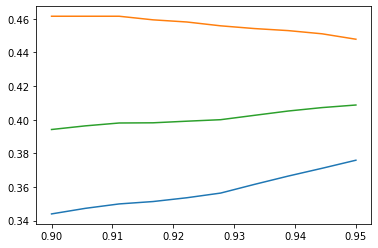

[0.95]


In [ ]:

best_threshold=[]
for k in range(1):
  m=0
  best_t=0
  prec_num = 0 
  prec_den = 0
  rec_num = 0
  rec_den = 0 
  threshold = np.linspace(1.9,1.99,5)
  f1 = []
  pre = []
  rec = []
  for t in threshold:
    for seq, mask, y in val_loader:
      bert_model.zero_grad()
      bert_model.eval()
      y_pred = bert_model(seq.to(device), mask.to(device))
      np_out = y_pred.cpu().data.numpy()
      np_act = y.cpu().data.numpy()
      #print(np_out)
      bert_model1.zero_grad()
      bert_model1.eval()
      y_pred1 = bert_model1(seq.to(device), mask.to(device))
      np_out1 = y_pred1.cpu().data.numpy()
    
      for i in range(np_out.shape[0]):
        for j in range(np_out.shape[1]):
          np_out[i,j,k] = np_out[i,j,k] + np_out1[i,j,k]
          if np_out[i][j][k]>=t:
            np_out[i][j][k]=1
          else:
            np_out[i][j][k]=0

      for i in range(np_out.shape[0]):
        for j in range(np_out.shape[1]):
          if np_out[i,j,k]==1:
            if np_out[i,j,k]==np_act[i,j,k]:
              prec_num = prec_num + 1
            else:
              prec_den = prec_den + 1
          if np_act[i,j,k]==1:
            if np_out[i,j,k]==np_act[i,j,k]:
              rec_num = rec_num + 1
            else:
              rec_den = rec_den + 1

    precision = prec_num/(prec_num+prec_den)
    recall = rec_num/(rec_num+rec_den)
    F1 = 2*precision*recall/(precision+recall)
    f1.append(F1)
    pre.append(precision)
    rec.append(recall)
    if F1>m:
      best_t = t
    m = max(m,F1)
  best_threshold.append(best_t)
  plt.plot(threshold,pre)
  plt.plot(threshold,rec)
  plt.plot(threshold,f1)
  plt.show()
print(best_threshold)

In [ ]:
p=0
n=0
pos=0
neg=0
prec_num = 0 
prec_den = 0
rec_num = 0
rec_den = 0 
p1 = 0
n1=0
for seq, mask, y in val_loader:
    bert_model.zero_grad()
    bert_model.eval()
    y_pred = bert_model(seq.to(device), mask.to(device))
    np_out = y_pred.cpu().data.numpy()
    np_act = y.cpu().data.numpy()
    #print(np_out)
    bert_model1.zero_grad()
    bert_model1.eval()
    y_pred1 = bert_model1(seq.to(device), mask.to(device))
    np_out1 = y_pred1.cpu().data.numpy()
    np_out2 = np_out1
    
    for i in range(np_out.shape[0]):
      for j in range(np_out.shape[1]):
        for k in range(np_out.shape[2]):
          t1=0.1
          t2=1.96
          np_out[i,j,k] = np_out[i,j,k] + np_out1[i,j,k]
          #print(np.max(np_out))
          #print(np.min(np_out2))
          if np_out[i][j][k]>=t2:
            np_out[i][j][k]=1
          else:
            np_out[i][j][k]=0

    for i in range(np_out.shape[0]):
      for j in range(np_out.shape[1]):
        if np.max(np_out[i,j,:])==1 or np.max(np_act[i,j,:])==1:
          if np.max(np_out[i,j,:])==1 and np.max(np_act[i,j,:])==1:
            p1 = p1 + 1
          else:
            n1 = n1 + 1

    for i in range(np_out.shape[0]):
      for j in range(np_out.shape[1]):
        for k in range(np_out.shape[2]):
          if np_out[i,j,k] == np_act[i,j,k]:
            p = p +1
          else:
            n=n+1
          if (np_out[i,j,k])==1 or (np_act[i,j,k])==1:
            if (np_out[i,j,k])==1 and (np_act[i,j,k])==1:
              pos = pos + 1
            else:
              neg = neg + 1
          if np_out[i,j,k]==1:
            if np_out[i,j,k]==np_act[i,j,k]:
              prec_num = prec_num + 1
            else:
              prec_den = prec_den + 1
          if np_act[i,j,k]==1:
            if np_out[i,j,k]==np_act[i,j,k]:
              rec_num = rec_num + 1
            else:
              rec_den = rec_den + 1

precision = prec_num/(prec_num+prec_den)
recall = rec_num/(rec_num+rec_den)
F1 = 2*precision*recall/(precision+recall)

print("Entity recognition modified accuracy:-" + str(p1/(p1+n1)))
print("--------NER RESULTS--------")
print("Accuracy:-" + str(p/(n+p)))
print("Modified Accuracy:-" + str(pos/(pos+neg)))
print("Precision:-" + str(precision))
print("Recall:-" + str(recall))
print("F1 score:-"+str(F1))

Entity recognition modified accuracy:-0.2694300518134715
--------NER RESULTS--------
Accuracy:-0.9986161275125628
Modified Accuracy:-0.2694300518134715
Precision:-0.40625
Recall:-0.4444444444444444
F1 score:-0.42448979591836733


In [ ]:
print(np.count_nonzero(lauda2))

464


In [ ]:
lauda = np.zeros((315,512))
f = 0
for seq, mask, y in train_loader:
    bert_model.zero_grad()
    bert_model.eval()
    y_pred = bert_model(seq.to(device), mask.to(device))
    np_out = y_pred.cpu().data.numpy()
    np_act = y.cpu().data.numpy()

    
    for i in range(np_out.shape[0]):
      for j in range(np_out.shape[1]):
        for k in range(np_out.shape[2]):
          t=0.8
          if np_out[i][j][k]>=t:
            np_out[i][j][k]=1
          else:
            np_out[i][j][k]=0
          lauda[f,j] = np_out[i,j,k]
      f = f + 1
 

In [ ]:
lauda2 = np.zeros((199,512))
f = 0
for seq, mask, y in val_loader:
    bert_model.zero_grad()
    bert_model.eval()
    y_pred = bert_model(seq.to(device), mask.to(device))
    np_out = y_pred.cpu().data.numpy()
    np_act = y.cpu().data.numpy()

    
    for i in range(np_out.shape[0]):
      for j in range(np_out.shape[1]):
        for k in range(np_out.shape[2]):
          t=0.7
          if np_out[i][j][k]>=t:
            np_out[i][j][k]=1
          else:
            np_out[i][j][k]=0
          lauda2[f,j] = np_out[i,j,k]
      f = f + 1
 

In [ ]:
train_data = TensorDataset(torch.from_numpy(train_seq), torch.from_numpy(lauda),torch.from_numpy(train_y))
val_data = TensorDataset(torch.from_numpy(val_seq), torch.from_numpy(lauda2),torch.from_numpy(val_y))

In [ ]:
batch_size = 38
train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size = batch_size)

In [ ]:
torch.save(bert_model,'/content/drive/My Drive/Model/MP_recall_52_ep30.pt')

In [ ]:
MP_recall_67_ep20.pt

In [ ]:
bert_model1=torch.load('/content/drive/My Drive/Model/MP_recall_52_ep30.pt')

In [ ]:
bert_model1=torch.load('/content/drive/My Drive/Model/MP_recall_67_ep20.pt')

In [ ]:
idx2labels = {0:"Quantity"}#, 1:"MeasuredEntity", 2: "MeasuredProperty", 3: "Qualifier"}

In [ ]:
s = "Please make sure the body of H2SO4 is in range between 2% and 3%"
tokenized_text = tokenizer.tokenize(s)
test_inputs = tokenizer(s,max_length = 512,padding='max_length',truncation=True, return_tensors="pt")
model.eval()
temp = bert_model(test_inputs['input_ids'].to(device), test_inputs['attention_mask'].to(device))>=0.95
#print(temp[0,:,0])

#temp[:,:,1] = temp[:,:,1]>0.1
#temp[:,:,2] = temp[:,:,2]>0.3
#temp[:,:,3] = temp[:,:,3]>0.1

In [ ]:
for i in range(len(tokenized_text)):
  print(tokenized_text[i] + ": ", end='')
  for j in range(1):
    if(temp[0][i+1][j]):
      print(idx2labels[j] + " ", end='')
  print()

please: 
make: 
sure: 
the: 
body: Quantity 
of: 
h: 
##2: 
##so: 
##4: 
is: 
in: 
range: 
between: 
2: 
%: 
and: 
3: 
%: 
